In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyodbc

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
import bisect 

from datetime import datetime
from printdescribe import changepath

from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

from statsmodels.tsa.stattools import kpss,adfuller

from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import pycaret

import warnings
warnings.filterwarnings('ignore')

In [2]:
drivers = [item for item in pyodbc.drivers()]
driver = drivers[-1]
print("driver:{}".format(driver))

driver:Microsoft Access Text Driver (*.txt, *.csv)


In [3]:
# path1 = r"C:\Users\HP\Downloads"
# with changepath(path1):
#     data = pd.read_csv("spy_vix.csv")
cnxn = pyodbc.connect('Trusted_Connection=yes', 
                     driver = '{ODBC Driver 17 for SQL Server}',
                     server = '.', 
                     database = 'TickHistory')

In [4]:
cursor = cnxn.cursor()
query = '''select Spy.Date_Time, SPY.Volume [SPY_Volume],
SPY.Last [SPY_Last], VIX.Last [VIX_Last]
FROM [TickHistory].[dbo].[raw_SPY_VIX_2019_2020] Spy
INNER JOIN [TickHistory].[dbo].[raw_SPY_VIX_2019_2020] Vix
ON Spy.Date_Time = Vix.Date_Time
AND Vix.RIC = '.VIX'
where Spy.RIC = 'SPY' 
and Spy.[Open] is not null
ORDER BY Spy.Date_Time'''
# query = '''select top 10 * from raw_SPY_VIX_2019_2020'''
# cursor.execute()
data = pd.read_sql(query, cnxn)
# cnxn.commit()
cursor.close()
data.tail(5)

,Date_Time,SPY_Volume,SPY_Last,VIX_Last
617355,2020-12-31T20:58:51.000000000Z,17587,374.26,22.64
617356,2020-12-31T20:59:06.000000000Z,110402,374.43,22.59
617357,2020-12-31T20:59:21.000000000Z,49541,374.32,22.56
617358,2020-12-31T20:59:36.000000000Z,44823,374.32,22.62
617359,2020-12-31T20:59:51.000000000Z,201248,374.63,22.51


In [5]:
df = data

In [6]:
df['TimeIndex']= df['Date_Time'].apply(lambda t:datetime.strptime(t[:-11], "%Y-%m-%dT%H:%M:%S"))

In [7]:
df.set_index("TimeIndex", inplace=True)

In [8]:
df = df[['SPY_Last','VIX_Last']]

In [9]:
df = df.astype('float64')

In [10]:
df = df.dropna()

In [11]:
from statsmodels.tsa.stattools import coint

In [12]:
# my_coint = coint(df['SPY_Last'][:-2], df['VIX_Last'].shift(-2).dropna(), trend='nc', method='aeg', autolag='bic')

In [13]:
# print(my_coint)

In [14]:
df_train = df[:int(len(df)*0.7)]
df_test = df[int(len(df)*0.7):int(len(df)*0.9)]
df_validation = df[int(len(df)*0.9):]

In [129]:
last_train_obs = str(df_train.iloc[-1].name)
last_test_obs = str(df_test.iloc[-1].name)
last_validation_obs = str(df_validation.iloc[-1].name)

In [119]:
# Difference the datasets twice
df_train_fd = df_train.diff().dropna()
df_test_fd = df_test.diff().dropna()
df_validation_fd = df_validation.diff().dropna()
df_train_sd = df_train_fd.diff().dropna()
df_test_sd = df_test_fd.diff().dropna()
df_validation_sd = df_validation_fd.diff().dropna()

In [16]:
'''LOOKIE LOOKIE'''
var_1 = VAR(df_train_sd)
var_1_fitted = var_1.fit(1, trend='nc')# Fit the model
print(var_1_fitted.summary())

C:\Users\cemre\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 17, Apr, 2021
Time:                     20:12:27
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -8.27171
Nobs:                     432149.    HQIC:                  -8.27179
Log likelihood:           560947.    FPE:                0.000255621
AIC:                     -8.27182    Det(Omega_mle):     0.000255618
--------------------------------------------------------------------
Results for equation SPY_Last
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
L1.SPY_Last        -0.479653         0.001395         -343.792           0.000
L1.VIX_Last         0.085040         0.002187           38.883           0.000

Results for equation VIX_Last
                 coefficient      

In [17]:
'''LOOKIE LOOKIE'''
var_2 = VAR(df_train_sd)
var_2_fitted = var_2.fit(2, trend='nc')# Fit the model
print(var_2_fitted.summary())

C:\Users\cemre\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 17, Apr, 2021
Time:                     20:12:28
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -8.55381
Nobs:                     432148.    HQIC:                  -8.55395
Log likelihood:           621924.    FPE:                0.000192771
AIC:                     -8.55401    Det(Omega_mle):     0.000192767
--------------------------------------------------------------------
Results for equation SPY_Last
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
L1.SPY_Last        -0.651488         0.001552         -419.662           0.000
L1.VIX_Last         0.058239         0.002475           23.530           0.000
L2.SPY_Last        -0.312047         0.001569         -198.943   

In [18]:
'''LOOKIE LOOKIE'''
var_3 = VAR(df_train_sd)
var_3_fitted = var_3.fit(3, trend='nc')# Fit the model
print(var_3_fitted.summary())

C:\Users\cemre\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 17, Apr, 2021
Time:                     20:12:28
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -8.68346
Nobs:                     432147.    HQIC:                  -8.68368
Log likelihood:           649964.    FPE:                0.000169312
AIC:                     -8.68377    Det(Omega_mle):     0.000169307
--------------------------------------------------------------------
Results for equation SPY_Last
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
L1.SPY_Last        -0.733171         0.001614         -454.132           0.000
L1.VIX_Last         0.048647         0.002610           18.637           0.000
L2.SPY_Last        -0.471951         0.001933         -244.209   

### PREDICTION

In [171]:
xx=var_3_fitted.forecast


In [196]:
df_test_sd.iloc[-6:]

,SPY_Last,VIX_Last
TimeIndex,,
2020-10-22 19:09:19,-0.04,1.000000e-02
2020-10-22 19:09:34,0.02,3.552714e-15
2020-10-22 19:09:49,0.06,-1.000000e-02
2020-10-22 19:10:49,-0.07,-3.000000e-02
2020-10-22 19:11:04,0.06,4.000000e-02
2020-10-22 19:11:19,-0.09,-2.000000e-02


In [192]:
df_test_sd.values[-2:-1]

array([[0.06, 0.04]])

In [195]:
xx(df_test_sd.values[-4:-1], 1)

array([[-0.025131  , -0.01755651]])

In [197]:
xx(df_test_sd.values[-5:-2], 1)

array([[0.01644961, 0.03289845]])

In [198]:
xx(df_test_sd.values[-6:-3], 1)

array([[-0.04443755, -0.00194063]])

In [199]:
xx(df_test_sd.values[-7:-4], 1)

array([[ 0.00199299, -0.00184683]])

In [201]:
xx(df_test_sd.values[-8:-5], 5)

array([[-0.01226839,  0.00582219],
       [ 0.02593447, -0.00259041],
       [-0.00342118, -0.00350515],
       [-0.0069654 ,  0.00117804],
       [ 0.00068725,  0.00152883]])

In [ ]:
var_3_fitted? #forecast(df_validation_sd['SPY_Last'],steps=1)

In [203]:
df_test_sd

,SPY_Last,VIX_Last
TimeIndex,,
2020-06-11 18:25:50,0.11,3.000000e-01
2020-06-11 18:26:05,-0.05,-2.500000e-01
2020-06-11 18:26:20,0.07,1.100000e-01
2020-06-11 18:26:35,-0.06,-3.000000e-02
2020-06-11 18:26:50,-0.09,3.000000e-02
...,...,...
2020-10-22 19:09:34,0.02,3.552714e-15
2020-10-22 19:09:49,0.06,-1.000000e-02
2020-10-22 19:10:49,-0.07,-3.000000e-02


In [19]:
df_train_lagged = df_train_sd.shift(1).dropna()
df_train_lagged_2 = df_train_sd.shift(2).dropna()
df_train_lagged_3 = df_train_sd.shift(3).dropna()

In [208]:
df_test_lagged = df_test_sd.shift(1).dropna()
df_test_lagged_2 = df_test_sd.shift(2).dropna()
df_test_lagged_3 = df_test_sd.shift(3).dropna()

In [209]:
df_validation_lagged = df_validation_sd.shift(1).dropna()
df_validation_lagged_2 = df_validation_sd.shift(2).dropna()
df_validation_lagged_3 = df_validation_sd.shift(3).dropna()

In [21]:
predicted_train_1 = var_1_fitted.coefs[0][0][0]*df_train_lagged['SPY_Last'] +\
var_1_fitted.coefs[0][0][1]*df_train_lagged['VIX_Last']

In [22]:
predicted_test_1 = var_1_fitted.coefs[0][0][0]*df_test_lagged['SPY_Last'] +\
var_1_fitted.coefs[0][0][1]*df_test_lagged['VIX_Last']

In [210]:
predicted_validation_1 = var_1_fitted.coefs[0][0][0]*df_validation_lagged['SPY_Last'] +\
var_1_fitted.coefs[0][0][1]*df_validation_lagged['VIX_Last']

In [211]:
predicted_validation_1

TimeIndex
2020-10-22 19:12:19    0.012362
2020-10-22 19:12:49   -0.024092
2020-10-22 19:13:04    0.023983
2020-10-22 19:13:19   -0.036824
2020-10-22 19:13:34   -0.004797
                         ...   
2020-12-31 20:58:51    0.047812
2020-12-31 20:59:06   -0.043713
2020-12-31 20:59:21   -0.070009
2020-12-31 20:59:36    0.136004
2020-12-31 20:59:51   -0.045108
Length: 61733, dtype: float64

In [24]:
predicted_train_2 = var_2_fitted.coefs[0][0][0]*df_train_lagged['SPY_Last'] +\
var_2_fitted.coefs[0][0][1]*df_train_lagged['VIX_Last'] +\
var_2_fitted.coefs[1][0][0]*df_train_lagged_2['SPY_Last'] +\
var_2_fitted.coefs[1][0][1]*df_train_lagged_2['VIX_Last']

In [25]:
predicted_test_2 = var_2_fitted.coefs[0][0][0]*df_test_lagged['SPY_Last'] +\
var_2_fitted.coefs[0][0][1]*df_test_lagged['VIX_Last'] +\
var_2_fitted.coefs[1][0][0]*df_test_lagged_2['SPY_Last'] +\
var_2_fitted.coefs[1][0][1]*df_test_lagged_2['VIX_Last']

In [26]:
predicted_test_3 = var_3_fitted.coefs[0][0][0]*df_test_lagged['SPY_Last'] +\
var_3_fitted.coefs[0][0][1]*df_test_lagged['VIX_Last'] +\
var_3_fitted.coefs[1][0][0]*df_test_lagged_2['SPY_Last'] +\
var_3_fitted.coefs[1][0][1]*df_test_lagged_2['VIX_Last'] +\
var_3_fitted.coefs[2][0][0]*df_test_lagged_3['SPY_Last'] +\
var_3_fitted.coefs[2][0][1]*df_test_lagged_3['VIX_Last'] 

In [213]:
predicted_train_undiff = 2*df_train['SPY_Last'].shift(1) - df_train['SPY_Last'].shift(2) + predicted_train_1
# predicted_train_undiff = 2*df_train['SPY_Last'].shift(1) - df_train['SPY_Last'].shift(2) + predicted_train_1
predicted_validation_undiff = 2*df_validation['SPY_Last'].shift(1) - df_validation['SPY_Last'].shift(2) + predicted_validation_1

In [28]:
predicted_train_undiff.dropna(inplace=True)

In [29]:
df_delta_1 = predicted_train_undiff-df_train['SPY_Last'][3:]

In [30]:
predicted_train_undiff.head(5)

TimeIndex
2019-01-02 14:31:49    246.498244
2019-01-02 14:32:04    246.635057
2019-01-02 14:32:19    246.477579
2019-01-02 14:32:34    246.299371
2019-01-02 14:32:49    246.444106
dtype: float64

In [215]:
predicted_validation_undiff.tail(5)

TimeIndex
2020-12-31 20:58:51    374.207812
2020-12-31 20:59:06    374.256287
2020-12-31 20:59:21    374.529991
2020-12-31 20:59:36    374.346004
2020-12-31 20:59:51    374.274892
dtype: float64

In [216]:
df_validation.tail(5)

,SPY_Last,VIX_Last
TimeIndex,,
2020-12-31 20:58:51,374.26,22.64
2020-12-31 20:59:06,374.43,22.59
2020-12-31 20:59:21,374.32,22.56
2020-12-31 20:59:36,374.32,22.62
2020-12-31 20:59:51,374.63,22.51


In [31]:
df_train['SPY_Last'][3:].head(5)

TimeIndex
2019-01-02 14:31:49    246.5511
2019-01-02 14:32:04    246.4700
2019-01-02 14:32:19    246.3800
2019-01-02 14:32:34    246.4500
2019-01-02 14:32:49    246.3900
Name: SPY_Last, dtype: float64

In [32]:
df_delta_1

TimeIndex
2019-01-02 14:31:49   -0.052856
2019-01-02 14:32:04    0.165057
2019-01-02 14:32:19    0.097579
2019-01-02 14:32:34   -0.150629
2019-01-02 14:32:49    0.054106
                         ...   
2020-06-11 18:24:05    0.075348
2020-06-11 18:24:20   -0.008902
2020-06-11 18:24:35   -0.158372
2020-06-11 18:24:50    0.171386
2020-06-11 18:25:05    0.032975
Length: 432149, dtype: float64

In [33]:
predicted_test_1_undiff = 2*df['SPY_Last'].shift(1) - df['SPY_Last'].shift(2) + predicted_test_1
predicted_test_2_undiff = 2*df['SPY_Last'].shift(1) - df['SPY_Last'].shift(2) + predicted_test_2
predicted_test_3_undiff = 2*df['SPY_Last'].shift(1) - df['SPY_Last'].shift(2) + predicted_test_3

In [34]:
predicted_test_1_undiff

TimeIndex
2019-01-02 14:31:04   NaN
2019-01-02 14:31:19   NaN
2019-01-02 14:31:34   NaN
2019-01-02 14:31:49   NaN
2019-01-02 14:32:04   NaN
                       ..
2020-12-31 20:58:51   NaN
2020-12-31 20:59:06   NaN
2020-12-31 20:59:21   NaN
2020-12-31 20:59:36   NaN
2020-12-31 20:59:51   NaN
Length: 617360, dtype: float64

In [35]:
def get_prediction_accuracy(method, expected, predicted):
    if method == 'MSE':
        accuracy = mean_squared_error(expected, predicted)
        return {method:accuracy}
    elif method == 'MAE':
        accuracy = mean_absolute_error(expected, predicted)
        return {method:accuracy}
#     else:
#         accuracy = mean_absolute_error(expected, predicted)
#         return {method:accuracy}

In [36]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [37]:
'''Here is a comparison of the various VAR(p) predictions. We have decided to abandon the forecast function 
and instead we will manually derive the predicted level datasets.'''
# Manual
# preds = [predicted_1_undiff.dropna(), predicted_2_undiff.dropna(), predicted_3_undiff.dropna()]
preds = [predicted_test_1_undiff.dropna(), predicted_test_2_undiff.dropna(), predicted_test_3_undiff.dropna()]
for i in range(0, len(preds)):
#     print (get_prediction_accuracy('MSE', df['SPY_Last'][3+i:], preds[i]))
#     print (get_prediction_accuracy('MAE', df['SPY_Last'][3+i:], preds[i]))
    print (get_prediction_accuracy('MSE', df_test['SPY_Last'][3+i:], preds[i]))
    print (get_prediction_accuracy('MAE', df_test['SPY_Last'][3+i:], preds[i]))


{'MSE': 0.01761297041411011}
{'MAE': 0.07506639186650572}
{'MSE': 0.015677563890730446}
{'MAE': 0.07078747474730565}
{'MSE': 0.014727283878118707}
{'MAE': 0.06840291999451488}


In [38]:
'''Here is a comparison of the various VAR(p) predictions. We have decided to abandon the forecast function 
and instead we will manually derive the predicted level datasets.'''
# Manual
# preds = [predicted_1_undiff.dropna(), predicted_2_undiff.dropna(), predicted_3_undiff.dropna()]
preds = [predicted_test_1.dropna(), predicted_test_2.dropna(), predicted_test_3.dropna()]
for i in range(0, len(preds)):
#     print (get_prediction_accuracy('MSE', df['SPY_Last'][3+i:], preds[i]))
#     print (get_prediction_accuracy('MAE', df['SPY_Last'][3+i:], preds[i]))
    print (get_prediction_accuracy('MSE', df_test_sd['SPY_Last'][1+i:], preds[i]))
    print (get_prediction_accuracy('MAE', df_test_sd['SPY_Last'][1+i:], preds[i]))


{'MSE': 0.017612970414110113}
{'MAE': 0.0750663918665058}
{'MSE': 0.015677563890730457}
{'MAE': 0.07078747474730562}
{'MSE': 0.014727283878118712}
{'MAE': 0.0684029199945149}


In [448]:
np.sqrt(0.017612970414110113)

0.13271386669866156

In [449]:
np.sqrt(0.015677563890730457)

0.12521007903012624

In [450]:
np.sqrt(0.014727283878118712)

0.12135602118608994

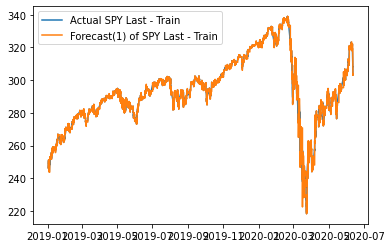

In [39]:
plt.plot(df_train['SPY_Last'], label='Actual SPY Last - Train')
plt.plot(predicted_train_undiff, label='Forecast(1) of SPY Last - Train')
# plt.plot(df_delta_1, label='Delta')
plt.legend()

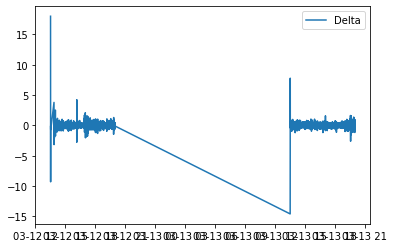

In [40]:
plt.plot(df_delta_1['2020-03-12':'2020-03-15'], label='Delta')
plt.legend()

In [41]:
df_delta_1['2020-03-12':'2020-03-15'].describe()

count    3047.000000
mean       -0.000049
std         0.654494
min       -14.590511
25%        -0.218337
50%        -0.007193
75%         0.213128
max        17.982796
dtype: float64

In [42]:
np.abs(df_delta_1).describe()

count    432149.000000
mean          0.067272
std           0.151839
min           0.000000
25%           0.016388
50%           0.037749
75%           0.076878
max          31.768009
dtype: float64

In [43]:
df_train_fd['2020-03-12':'2020-03-15'].to_csv('delta_train_fd.csv')

In [44]:
df_train_sd['2020-03-12':'2020-03-15'].to_csv('delta_train_sd.csv')

In [45]:
df_train['2020-03-11':'2020-03-15'].to_csv('train.csv')

### ARIMA

In [46]:
from statsmodels.tsa.arima.model import ARIMA

In [47]:
'''Fit ARIMA(1,0,0)'''
arima_1 = ARIMA(df_train_sd['SPY_Last'], df_train_sd['VIX_Last'], order=(1,0,0))
res_arima_1 = arima_1.fit()
print(res_arima_1.summary())

C:\Users\cemre\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\cemre\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\cemre\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


                               SARIMAX Results                                
Dep. Variable:               SPY_Last   No. Observations:               432150
Model:                 ARIMA(1, 0, 0)   Log Likelihood              195974.048
Date:                Sat, 17 Apr 2021   AIC                        -391940.095
Time:                        20:13:06   BIC                        -391896.189
Sample:                             0   HQIC                       -391927.590
                             - 432150                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -5.094e-06      0.000     -0.032      0.974      -0.000       0.000
VIX_Last      -0.6057   6.92e-05  -8751.409      0.000      -0.606      -0.606
ar.L1         -0.5307   3.01e-05  -1.76e+04      0.0

In [48]:
'''Fit ARIMA(1,0,1) on train dataset'''
arima_101 = ARIMA(df_train_sd['SPY_Last'], df_train_sd['VIX_Last'], order=(1,0,1))
res_arima_101 = arima_101.fit()
print(res_arima_101.summary())

C:\Users\cemre\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\cemre\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\cemre\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\cemre\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge.

                               SARIMAX Results                                
Dep. Variable:               SPY_Last   No. Observations:               432150
Model:                 ARIMA(1, 0, 1)   Log Likelihood              291718.219
Date:                Sat, 17 Apr 2021   AIC                        -583426.439
Time:                        20:17:16   BIC                        -583371.556
Sample:                             0   HQIC                       -583410.807
                             - 432150                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -3.241e-06   1.73e-06     -1.871      0.061   -6.64e-06    1.54e-07
VIX_Last      -0.7373   6.26e-05  -1.18e+04      0.000      -0.737      -0.737
ar.L1         -0.0961      0.000   -808.200      0.0

Forecasting Techniques
- https://github.com/statsmodels/statsmodels/issues/3623
- https://github.com/statsmodels/statsmodels/issues/2788


In [120]:
'''Fit ARIMA(1,0,1) on validation dataset'''
arima_validation_101 = ARIMA(df_validation_sd['SPY_Last'], df_validation_sd['VIX_Last'], order=(1,0,1))
res_arima_validation_101 = arima_validation_101.fit()
print(res_arima_validation_101.summary())

C:\Users\cemre\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\cemre\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\cemre\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\cemre\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge.

                               SARIMAX Results                                
Dep. Variable:               SPY_Last   No. Observations:                61734
Model:                 ARIMA(1, 0, 1)   Log Likelihood               57904.815
Date:                Sat, 17 Apr 2021   AIC                        -115799.630
Time:                        21:40:47   BIC                        -115754.477
Sample:                             0   HQIC                       -115785.623
                              - 61734                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -7.976e-07   1.18e-06     -0.676      0.499   -3.11e-06    1.52e-06
VIX_Last      -1.1365      0.000  -2511.673      0.000      -1.137      -1.136
ar.L1         -0.1218      0.001   -205.695      0.0

In [49]:
mse_101 = np.sqrt(np.mean(res_arima_101.resid[3:]**2))
mae_101 = np.mean(np.abs(res_arima_101.resid[3:]))

In [50]:
print('MSE: ', mse_101)
print('MAE: ', mae_101)

MSE:  0.12314853685640616
MAE:  0.04939551945366293


In [51]:
ARIMA?

In [52]:
df_test_lagged['SPY_Last']

TimeIndex
2020-06-11 18:26:05    0.11
2020-06-11 18:26:20   -0.05
2020-06-11 18:26:35    0.07
2020-06-11 18:26:50   -0.06
2020-06-11 18:27:05   -0.09
                       ... 
2020-10-22 19:09:34   -0.04
2020-10-22 19:09:49    0.02
2020-10-22 19:10:49    0.06
2020-10-22 19:11:04   -0.07
2020-10-22 19:11:19    0.06
Name: SPY_Last, Length: 123469, dtype: float64

In [53]:
df_test_sd['VIX_Last']

TimeIndex
2020-06-11 18:25:50    3.000000e-01
2020-06-11 18:26:05   -2.500000e-01
2020-06-11 18:26:20    1.100000e-01
2020-06-11 18:26:35   -3.000000e-02
2020-06-11 18:26:50    3.000000e-02
                           ...     
2020-10-22 19:09:34    3.552714e-15
2020-10-22 19:09:49   -1.000000e-02
2020-10-22 19:10:49   -3.000000e-02
2020-10-22 19:11:04    4.000000e-02
2020-10-22 19:11:19   -2.000000e-02
Name: VIX_Last, Length: 123470, dtype: float64

In [54]:
# predict_arima_101_test_sd =res_arima_101.params[0] + res_arima_1.params[1]*df_test_sd['VIX_Last'] + res_arima_1.params[2]*df_test_lagged_sd['SPY_Last'] + res_arima_1.params[3]*df_test_lagged['SPY_Last']+ res_arima_1.params[3]

In [55]:
res_arima_101.params[0]

-3.2408345313344327e-06

In [56]:
p = res_arima_101.get_prediction(start=-20)

In [57]:
len(res_arima_101.forecasts[0])

432150

In [58]:
# print(p.predictions)

In [61]:
# res_arima_101.get_forecast(steps=1)
# res_arima_101.get_forecast(steps=1)

In [62]:
# my_summary.as_latex()

In [63]:
# predict_arima_sd = -0.6168*df_train_sd['VIX_Last'] - 0.5331*df_train_lagged['SPY_Last'] + 0.0223 

In [64]:
# for i in res_arima_1.params.index:
#     if i != 'const':
#         res_arima_1.params[i]
# res_arima_1.params['const']
print(res_arima_1.params[1])
print(res_arima_1.params[2])
print(res_arima_1.params[3])

-0.6056504416266216
-0.5306712130853932
0.023637624854561015


In [65]:
predict_arima_sd = res_arima_1.params[1]*df_train_sd['VIX_Last'] + res_arima_1.params[2]*df_train_lagged['SPY_Last'] + res_arima_1.params[3]
# predict_arima_test_sd = res_arima_1.params[1]*df_test_sd['VIX_Last'] + res_arima_1.params[2]*df_test_lagged['SPY_Last'] + res_arima_1.params[3]

In [66]:
sma_20 = df.rolling(20).mean()

In [67]:
resid_20 = df - sma_20

In [68]:
print(resid_20)

                     SPY_Last  VIX_Last
TimeIndex                              
2019-01-02 14:31:04       NaN       NaN
2019-01-02 14:31:19       NaN       NaN
2019-01-02 14:31:34       NaN       NaN
2019-01-02 14:31:49       NaN       NaN
2019-01-02 14:32:04       NaN       NaN
...                       ...       ...
2020-12-31 20:58:51   0.10675     0.058
2020-12-31 20:59:06   0.26225     0.007
2020-12-31 20:59:21   0.14300    -0.023
2020-12-31 20:59:36   0.13525     0.033
2020-12-31 20:59:51   0.41900    -0.074

[617360 rows x 2 columns]


In [69]:
df[int(len(df)*0.9):]

,SPY_Last,VIX_Last
TimeIndex,,
2020-10-22 19:11:34,344.080,28.17
2020-10-22 19:11:49,344.052,28.16
2020-10-22 19:12:04,344.000,28.16
2020-10-22 19:12:19,344.000,28.17
2020-10-22 19:12:49,343.950,28.18
...,...,...
2020-12-31 20:58:51,374.260,22.64
2020-12-31 20:59:06,374.430,22.59
2020-12-31 20:59:21,374.320,22.56


In [70]:
predict_arima_test_sd = res_arima_1.params[1]*df_test_sd['VIX_Last'] + res_arima_1.params[2]*df_test_lagged['SPY_Last'] + res_arima_1.params[3]

In [71]:
predict_arima_test_sd.head(5)

TimeIndex
2020-06-11 18:25:50         NaN
2020-06-11 18:26:05    0.116676
2020-06-11 18:26:20   -0.016450
2020-06-11 18:26:35    0.004660
2020-06-11 18:26:50    0.037308
dtype: float64

In [72]:
df_test_sd['SPY_Last'].head(5)

TimeIndex
2020-06-11 18:25:50    0.11
2020-06-11 18:26:05   -0.05
2020-06-11 18:26:20    0.07
2020-06-11 18:26:35   -0.06
2020-06-11 18:26:50   -0.09
Name: SPY_Last, dtype: float64

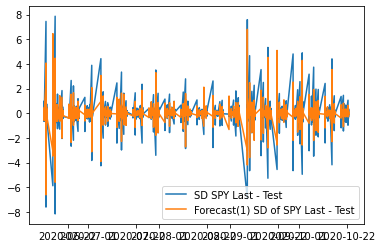

In [73]:
plt.plot(df_test_sd['SPY_Last'], label='SD SPY Last - Test')
plt.plot(predict_arima_test_sd, label='Forecast(1) SD of SPY Last - Test')
# plt.plot(df_delta_1, label='Delta')
plt.legend()

In [74]:
predicted_arima_test_1_undiff = 2*df_test['SPY_Last'].shift(1) - df_test['SPY_Last'].shift(2) + predict_arima_test_sd
predicted_arima_test_1_undiff.dropna(inplace=True)

In [75]:
print(get_prediction_accuracy('MSE', df_test['SPY_Last'][3:], predicted_arima_test_1_undiff))
print(get_prediction_accuracy('MAE', df_test['SPY_Last'][3:], predicted_arima_test_1_undiff))

{'MSE': 0.015538607786140699}
{'MAE': 0.0761275176379745}


In [76]:
# predict_arima_test_sd.dropna()
# Second-differenced datasets are better, more accurate to compare
print('sd ', get_prediction_accuracy('MSE', df_test_sd['SPY_Last'][1:], predict_arima_test_sd.dropna()))
print('sd ', get_prediction_accuracy('MAE', df_test_sd['SPY_Last'][1:], predict_arima_test_sd.dropna()))

sd  {'MSE': 0.01553860778614069}
sd  {'MAE': 0.07612751763797448}


ARIMA(1,0,0) seems to be more accurate than VAR(1) and possibly VAR(2) but less accurate than VAR(3) on the out-of-sample dataset

In [77]:
'''Let us try ARIMA(2,0,0)'''
arima_2 = ARIMA(df_train_sd['SPY_Last'], df_train_sd['VIX_Last'], order=(2,0,0))
res_arima_2 = arima_2.fit()
print(res_arima_2.summary())

C:\Users\cemre\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\cemre\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\cemre\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


                               SARIMAX Results                                
Dep. Variable:               SPY_Last   No. Observations:               432150
Model:                 ARIMA(2, 0, 0)   Log Likelihood              225948.485
Date:                Sat, 17 Apr 2021   AIC                        -451886.971
Time:                        20:19:14   BIC                        -451832.088
Sample:                             0   HQIC                       -451871.339
                             - 432150                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -5.082e-06      0.000     -0.045      0.964      -0.000       0.000
VIX_Last      -0.6513   6.02e-05  -1.08e+04      0.000      -0.651      -0.651
ar.L1         -0.7256   5.05e-05  -1.44e+04      0.0

In [311]:
'''Let us try ARIMA(2,1,1)'''
arima_22 = ARIMA(df_train['SPY_Last'], df_train['VIX_Last'], order=(2,1,1))
res_arima_22 = arima_22.fit()
print(res_arima_22.summary())

C:\Users\cemre\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\cemre\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\cemre\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


                               SARIMAX Results                                
Dep. Variable:               SPY_Last   No. Observations:               432152
Model:                 ARIMA(2, 1, 1)   Log Likelihood              293764.089
Date:                Sat, 17 Apr 2021   AIC                        -587518.179
Time:                        23:47:02   BIC                        -587463.296
Sample:                             0   HQIC                       -587502.547
                             - 432152                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
VIX_Last      -0.6930   4.26e-05  -1.63e+04      0.000      -0.693      -0.693
ar.L1          0.0893      0.010      9.310      0.000       0.071       0.108
ar.L2         -0.0100      0.001     -9.543      0.0

In [312]:
'''Let us try ARIMA(2,1,1)'''
arima_validation_22 = ARIMA(df_validation['SPY_Last'], df_validation['VIX_Last'], order=(2,1,1))
res_arima_validation_22 = arima_22.filter(res_arima_22.params)
print(res_arima_validation_22.summary())

C:\Users\cemre\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\cemre\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\cemre\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


                               SARIMAX Results                                
Dep. Variable:               SPY_Last   No. Observations:               432152
Model:                 ARIMA(2, 1, 1)   Log Likelihood              293764.089
Date:                Sat, 17 Apr 2021   AIC                        -587518.179
Time:                        23:47:49   BIC                        -587463.296
Sample:                             0   HQIC                       -587502.547
                             - 432152                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
VIX_Last      -0.6930   4.26e-05  -1.63e+04      0.000      -0.693      -0.693
ar.L1          0.0893      0.010      9.310      0.000       0.071       0.108
ar.L2         -0.0100      0.001     -9.543      0.0

In [313]:
arima_22_forecast = res_arima_validation_22.forecast(steps=1, exog=df_validation_fd['VIX_Last'].iloc[5])

C:\Users\cemre\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


In [403]:
arima_22_forecast

,arima
TimeIndex,
2020-10-22 19:11:34,309.614204
2020-10-22 19:11:49,309.621134
2020-10-22 19:12:04,309.621134
2020-10-22 19:12:19,309.614204
2020-10-22 19:12:49,309.607274
...,...
2020-12-31 20:58:51,313.446476
2020-12-31 20:59:06,313.481126
2020-12-31 20:59:21,313.501916


In [322]:
import warnings
warnings.filterwarnings('ignore')

arima_22 = []
for i in range(len(df_validation)):
    arima_22.append(res_arima_validation_22.forecast(steps=1, exog=df_validation['VIX_Last'].iloc[i]))
print(arima_22_forecast)

Empty DataFrame
Columns: []
Index: []


In [348]:
ar = []
for i in range(len(arima_22)):
    ar.append(arima_22[i].iloc[0])
arima_22_forecast = pd.DataFrame(index=df_validation['VIX_Last'].index)
arima_22_forecast = pd.DataFrame({'arima':ar}, index=df_validation['VIX_Last'].index)
arima_22_forecast

,arima
TimeIndex,
2020-10-22 19:11:34,309.614204
2020-10-22 19:11:49,309.621134
2020-10-22 19:12:04,309.621134
2020-10-22 19:12:19,309.614204
2020-10-22 19:12:49,309.607274
...,...
2020-12-31 20:58:51,313.446476
2020-12-31 20:59:06,313.481126
2020-12-31 20:59:21,313.501916


In [346]:
ar = []
for i in range(len(arima_22)):
    ar.append(arima_22[i].iloc[0])
ar

[309.614204006251,
 309.6211339734354,
 309.6211339734354,
 309.614204006251,
 309.60727403906657,
 309.60727403906657,
 309.60727403906657,
 309.614204006251,
 309.60727403906657,
 309.6211339734354,
 309.6211339734354,
 309.6211339734354,
 309.6211339734354,
 309.6280639406198,
 309.6280639406198,
 309.6419238749886,
 309.65578380935744,
 309.6627137765418,
 309.6696437437262,
 309.6696437437262,
 309.67657371091065,
 309.70429357964827,
 309.70429357964827,
 309.6904336452794,
 309.6904336452794,
 309.70429357964827,
 309.71815351401705,
 309.72508348120147,
 309.72508348120147,
 309.7320134483859,
 309.72508348120147,
 309.7320134483859,
 309.72508348120147,
 309.72508348120147,
 309.72508348120147,
 309.72508348120147,
 309.72508348120147,
 309.71815351401705,
 309.71815351401705,
 309.71815351401705,
 309.7320134483859,
 309.7389434155703,
 309.7389434155703,
 309.7320134483859,
 309.7320134483859,
 309.72508348120147,
 309.7320134483859,
 309.74587338275467,
 309.74587338275467,

In [345]:
len(arima_22)

61736

In [320]:
arima_22_forecast.head(5)

""


In [321]:
df_validation_fd.head(5)

,SPY_Last,VIX_Last
TimeIndex,,
2020-10-22 19:11:49,-0.028,-0.01
2020-10-22 19:12:04,-0.052,0.00
2020-10-22 19:12:19,0.000,0.01
2020-10-22 19:12:49,-0.050,0.01
2020-10-22 19:13:04,0.025,0.00


In [305]:
arima_22_forecast.rolling()

432151   -0.000033
dtype: float64

In [78]:
# predict_arima_sd = res_arima_1.params[1]*df_train_sd['VIX_Last'] + res_arima_1.params[2]*df_train_lagged['SPY_Last'] + res_arima_1.params[3]
predict_arima2_test_sd = res_arima_2.params[1]*df_test_sd['VIX_Last'] + res_arima_2.params[2]*df_test_lagged['SPY_Last'] + res_arima_2.params[3]*df_test_lagged_2['SPY_Last'] + res_arima_2.params[4]

In [79]:
# predict_arima_test_sd.dropna()
# Second-differenced datasets are better, more accurate to compare
print('sd ', get_prediction_accuracy('MSE', df_test_sd['SPY_Last'][2:], predict_arima2_test_sd.dropna()))
print('sd ', get_prediction_accuracy('MAE', df_test_sd['SPY_Last'][2:], predict_arima2_test_sd.dropna()))

sd  {'MSE': 0.014073246410637591}
sd  {'MAE': 0.07196482270566078}


### Cointegration Test

In [80]:
np.corrcoef(df['SPY_Last'][:-2], df['VIX_Last'].shift(-2).dropna())

array([[ 1.       , -0.2385576],
       [-0.2385576,  1.       ]])

In [81]:
df.corr()

,SPY_Last,VIX_Last
SPY_Last,1.000000,-0.238583
VIX_Last,-0.238583,1.000000


In [82]:
# print(my_coint)
# print(my_coint.crit_value)
# print(my_coint.pvalue)

The p-value is 0.154 so we do not have enough evidence to reject the Null hypothesis that there is no cointegration 

In [83]:
# print(my_coint)

In [84]:
df_test.head(5)

,SPY_Last,VIX_Last
TimeIndex,,
2020-06-11 18:25:20,303.91,36.56
2020-06-11 18:25:35,303.84,36.41
2020-06-11 18:25:50,303.88,36.56
2020-06-11 18:26:05,303.87,36.46
2020-06-11 18:26:20,303.93,36.47


In [85]:
df_test['VIX_Last'].shift(2)

TimeIndex
2020-06-11 18:25:20      NaN
2020-06-11 18:25:35      NaN
2020-06-11 18:25:50    36.56
2020-06-11 18:26:05    36.41
2020-06-11 18:26:20    36.56
                       ...  
2020-10-22 19:09:34    28.17
2020-10-22 19:09:49    28.18
2020-10-22 19:10:49    28.19
2020-10-22 19:11:04    28.19
2020-10-22 19:11:19    28.16
Name: VIX_Last, Length: 123472, dtype: float64

### GARCH

In [86]:
from arch.univariate import ConstantMean, GARCH, Normal, arch_model

In [87]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [88]:
def get_prediction_accuracy(method, expected, predicted):
    if method == 'MSE':
        accuracy = mean_squared_error(expected, predicted)
        return {method:accuracy}
    elif method == 'MAE':
        accuracy = mean_absolute_error(expected, predicted)
        return {method:accuracy}
#     else:
#         accuracy = mean_absolute_error(expected, predicted)
#         return {method:accuracy}

In [89]:
var_3_fitted.coefs[2][0][0]

-0.21606740785177708

- Consider ARIMA and GARCH?
- VIX vs no VIX
- VAR(p) where p = 1 to 5? Determine parsimony (elbow) rule
- Train vs test dataset
- Forecast(1) vs Forecast(up to 5)

In [90]:
predicted_1_undiff = 2*df_test['SPY_Last'].shift(1) - df_test['SPY_Last'].shift(2) + predicted_test_1
predicted_2_undiff = 2*df_test['SPY_Last'].shift(1) - df_test['SPY_Last'].shift(2) + predicted_test_2
predicted_3_undiff = 2*df_test['SPY_Last'].shift(1) - df_test['SPY_Last'].shift(2) + predicted_test_3

In [91]:
predicted_1_undiff.dropna(inplace=True)

In [92]:
preds = [predicted_1_undiff.dropna(), predicted_2_undiff.dropna(), predicted_3_undiff.dropna()]
for i in range(0, len(preds)):
    print (get_prediction_accuracy('MSE', df_test['SPY_Last'][3+i:], preds[i]))
    print (get_prediction_accuracy('MAE', df_test['SPY_Last'][3+i:], preds[i]))
#     print (get_prediction_accuracy('MAPE', df['SPY_Last'][3+i:], preds[i]))

{'MSE': 0.01761297041411011}
{'MAE': 0.07506639186650572}
{'MSE': 0.015677563890730446}
{'MAE': 0.07078747474730565}
{'MSE': 0.014727283878118707}
{'MAE': 0.06840291999451488}


In [93]:
print(get_prediction_accuracy('MSE', df_test['SPY_Last'][3:], predicted_1_undiff))

{'MSE': 0.01761297041411011}


In [94]:
# plt.plot(df_second['SPY_Last'], label='Actual SD of SPY')
# plt.plot(predicted_1, label='Predicted VAR(1) SD of SPY')
# plt.legend()

In [95]:
def rebuild_diffed_get_fd(series, previous_series):
    cumsum = series.cumsum()
    undiff = cumsum.fillna(0) + previous_series.iloc[0]
    return previous_series.head(2).append(undiff)
def rebuild_diffed_get_undiff(series, previous_series):
    cumsum = series.cumsum()
    undiff = cumsum.fillna(0) + previous_series.iloc[0]
    return previous_series.head(1).append(undiff)
# assert rebuild_diffed(df_log_returns_no_vol_fd, df_log_returns_no_vol).equals(df_log_returns_no_vol)
# rebuild_diffed(rebuild_diffed(df_log_returns_no_vol_fd, df_log_returns_no_vol), df_original)

In [96]:
from arch.univariate import HARX, GARCH

In [97]:
harx = HARX(df['SPY_Last'],df['VIX_Last'])
harx.volatility = GARCH()

C:\Users\cemre\anaconda3\lib\site-packages\arch\univariate\mean.py:506: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  self._x = self._x[:, None]


In [98]:
harx_res = harx.fit()

Iteration:      1,   Func. Count:      7,   Neg. LLF: 134936907391.35071
Iteration:      2,   Func. Count:     22,   Neg. LLF: 7061280.401353186
Iteration:      3,   Func. Count:     33,   Neg. LLF: 33552051503855.78
Iteration:      4,   Func. Count:     42,   Neg. LLF: 174773488.58569583
Iteration:      5,   Func. Count:     51,   Neg. LLF: 5116440.084369458
Iteration:      6,   Func. Count:     58,   Neg. LLF: 4360100.534384726
Iteration:      7,   Func. Count:     67,   Neg. LLF: 2.785815017146035e+19
Iteration:      8,   Func. Count:     83,   Neg. LLF: 1301564135736.7393
Iteration:      9,   Func. Count:     91,   Neg. LLF: 1849414814.0666096
Iteration:     10,   Func. Count:     99,   Neg. LLF: 10317160873.224895
Iteration:     11,   Func. Count:    112,   Neg. LLF: 12288478285300.15
Iteration:     12,   Func. Count:    121,   Neg. LLF: 64729233953769.2
Iteration:     13,   Func. Count:    133,   Neg. LLF: 210068465682.31183
Iteration:     14,   Func. Count:    148,   Neg. LLF: 6

In [99]:
print(harx_res.summary())

                         HAR-X - GARCH Model Results                          
Dep. Variable:               SPY_Last   R-squared:                      -0.177
Mean Model:                     HAR-X   Adj. R-squared:                 -0.177
Vol Model:                      GARCH   Log-Likelihood:           -2.47950e+06
Distribution:                  Normal   AIC:                       4.95901e+06
Method:            Maximum Likelihood   BIC:                       4.95906e+06
                                        No. Observations:               617360
Date:                Sat, Apr 17 2021   Df Residuals:                   617358
Time:                        20:20:04   Df Model:                            2
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
Const        309.9831  2.943e-02  1.053e+04      0.000 [3.

In [100]:
df_train_fd.describe()

,SPY_Last,VIX_Last
count,432151.000000,432151.000000
mean,0.000133,0.000021
std,0.135833,0.086337
min,-31.755000,-10.120000
25%,-0.030000,-0.010000
50%,0.000000,0.000000
75%,0.030000,0.010000
max,14.700000,18.520000


In [451]:
'''GARCH(1,1)'''
split_date = '2020-08-18 13:42:04'
model = arch_model(df['SPY_Last'],df['VIX_Last'], vol='GARCH', p=1, q=1)
results=model.fit(last_obs=split_date)
print(results.summary())
# garch_model = GARCH(p=1,q=1)

Iteration:      1,   Func. Count:      6,   Neg. LLF: 36603218.55310997
Iteration:      2,   Func. Count:     14,   Neg. LLF: 1988602.0582401706
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1988602.0536825282
            Iterations: 6
            Function evaluations: 14
            Gradient evaluations: 2
                     Constant Mean - GARCH Model Results                      
Dep. Variable:               SPY_Last   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:           -1.98860e+06
Distribution:                  Normal   AIC:                       3.97721e+06
Method:            Maximum Likelihood   BIC:                       3.97726e+06
                                        No. Observations:               493887
Date:                Tue, Apr 20 2021   Df Residuals:                   493886
Time:          

In [452]:
garch2_model = arch_model(df['SPY_Last'],df['VIX_Last'], vol='GARCH', p=2, q=1)

In [ ]:
garch2_model.

In [412]:
'''GARCH(2,1)'''
split_date = '2020-08-18 13:42:04'
model = arch_model(df['SPY_Last'],df['VIX_Last'], vol='GARCH', p=2, q=1)
results=model.fit(last_obs=split_date)
print(results.summary())
# garch_model = GARCH(p=1,q=1)

Iteration:      1,   Func. Count:      7,   Neg. LLF: 5836174.962095218
Iteration:      2,   Func. Count:     18,   Neg. LLF: 9489837377684.5
Iteration:      3,   Func. Count:     25,   Neg. LLF: 3624689.965961561
Iteration:      4,   Func. Count:     33,   Neg. LLF: 1896169.609124582
Iteration:      5,   Func. Count:     41,   Neg. LLF: 2266472.220494934
Iteration:      6,   Func. Count:     48,   Neg. LLF: 1943373.9376105347
Iteration:      7,   Func. Count:     55,   Neg. LLF: 1910699.8591121305
Iteration:      8,   Func. Count:     61,   Neg. LLF: 1923877.7660579314
Iteration:      9,   Func. Count:     77,   Neg. LLF: 2071173.0867110938
Iteration:     10,   Func. Count:     86,   Neg. LLF: 1887390.983584381
Iteration:     11,   Func. Count:     92,   Neg. LLF: 1883685.0688952093
Iteration:     12,   Func. Count:    100,   Neg. LLF: 1885851.7180488014
Iteration:     13,   Func. Count:    107,   Neg. LLF: 1932921.6676653572
Iteration:     14,   Func. Count:    114,   Neg. LLF: 18863

In [413]:
'''GARCH(2,2)'''
split_date = '2020-08-18 13:42:04'
model = arch_model(df['SPY_Last'],df['VIX_Last'], vol='GARCH', p=2, q=2)
results=model.fit(last_obs=split_date)
print(results.summary())
# garch_model = GARCH(p=1,q=1)

Iteration:      1,   Func. Count:      8,   Neg. LLF: 5836179.094753608
Iteration:      2,   Func. Count:     20,   Neg. LLF: 81626705126288.36
Iteration:      3,   Func. Count:     29,   Neg. LLF: 284286448.7429628
Iteration:      4,   Func. Count:     38,   Neg. LLF: 1895609.8437133804
Iteration:      5,   Func. Count:     45,   Neg. LLF: 2655878.8108311463
Iteration:      6,   Func. Count:     62,   Neg. LLF: 10749591497.847977
Iteration:      7,   Func. Count:     72,   Neg. LLF: 365115939346.1591
Iteration:      8,   Func. Count:     80,   Neg. LLF: 2424613.640532757
Iteration:      9,   Func. Count:     88,   Neg. LLF: 5021509780.186947
Iteration:     10,   Func. Count:     97,   Neg. LLF: 2472787.7626845567
Iteration:     11,   Func. Count:    107,   Neg. LLF: 2320868.775610346
Iteration:     12,   Func. Count:    115,   Neg. LLF: 1888950.8916770606
Iteration:     13,   Func. Count:    122,   Neg. LLF: 1888942.901551392
Iteration:     14,   Func. Count:    129,   Neg. LLF: 18889

In [380]:
results.conditional_volatility

TimeIndex
2019-01-02 14:31:04    48.113916
2019-01-02 14:31:19    47.320159
2019-01-02 14:31:34    46.682284
2019-01-02 14:31:49    46.166663
2019-01-02 14:32:04    45.738859
                         ...    
2020-12-31 20:58:51          NaN
2020-12-31 20:59:06          NaN
2020-12-31 20:59:21          NaN
2020-12-31 20:59:36          NaN
2020-12-31 20:59:51          NaN
Name: cond_vol, Length: 617360, dtype: float64

Fit an VAR/ARIMA(1,0,0). On the original data, this would be ARIMA(1,2,0). Fit GARCH(1,1) on the residuals taken from VAR/ARIMA. Assume residuals are highly volatile and mean 0.

In [102]:
garch_prediction = results.forecast(horizon=1, start=split_date)
# garch_prediction = results.forecast(horizon=5, start=split_date)
garch_prediction.variance

C:\Users\cemre\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


,h.1
TimeIndex,
2019-01-02 14:31:04,NaN
2019-01-02 14:31:19,NaN
2019-01-02 14:31:34,NaN
2019-01-02 14:31:49,NaN
2019-01-02 14:32:04,NaN
...,...
2020-12-31 20:58:51,6102.434207
2020-12-31 20:59:06,6109.190332
2020-12-31 20:59:21,6110.854105


We will forecast ARIMA(1,0,1) for rolling mean

Need the following: VAR(1)(predicted_validation_undiff), ARIMA(2,1,1) (arima_22_forecast), GARCH(1,1) volatilities (garch_prediction), SPY actuals (df_validation['SPY_Last']). Using VAR(1), sma_20 (simple 20-day moving average) and SPY actuals we can construct a one-period forecast of the simple-moving average

In [224]:
# var_predictions = pd.DataFrame(predicted_test_1_undiff)

In [225]:
actuals_for_ma = df_validation['SPY_Last'].copy()

In [226]:
actuals_for_ma = pd.DataFrame(actuals_for_ma)
p = pd.DataFrame(df_test['SPY_Last'][-20:])
p.rename(columns={0:'SPY_Last'})
p
actuals_for_ma = pd.concat([p,actuals_for_ma],axis=0)

In [228]:
actuals_for_ma

,SPY_Last
TimeIndex,
2020-10-22 19:05:34,344.220
2020-10-22 19:05:49,344.275
2020-10-22 19:06:04,344.160
2020-10-22 19:06:19,343.970
2020-10-22 19:06:34,344.030
...,...
2020-12-31 20:58:51,374.260
2020-12-31 20:59:06,374.430
2020-12-31 20:59:21,374.320


In [229]:
df_var = pd.DataFrame(predicted_validation_undiff)
df_var.rename(columns={0:'VAR_1'},inplace=True)
df_var

,VAR_1
TimeIndex,
2020-10-22 19:11:34,NaN
2020-10-22 19:11:49,NaN
2020-10-22 19:12:04,NaN
2020-10-22 19:12:19,343.960362
2020-10-22 19:12:49,343.975908
...,...
2020-12-31 20:58:51,374.207812
2020-12-31 20:59:06,374.256287
2020-12-31 20:59:21,374.529991


In [230]:
spy_and_var_for_ma = actuals_for_ma.join(df_var)
# spy_and_var_for_Ma

In [445]:
spy_and_var_for_ma

,SPY_Last,VAR_1
TimeIndex,,
2020-10-22 19:05:34,344.220,NaN
2020-10-22 19:05:49,344.275,NaN
2020-10-22 19:06:04,344.160,NaN
2020-10-22 19:06:19,343.970,NaN
2020-10-22 19:06:34,344.030,NaN
...,...,...
2020-12-31 20:58:51,374.260,374.207812
2020-12-31 20:59:06,374.430,374.256287
2020-12-31 20:59:21,374.320,374.529991


In [310]:
garch_prediction.variance

,h.1
TimeIndex,
2019-01-02 14:31:04,NaN
2019-01-02 14:31:19,NaN
2019-01-02 14:31:34,NaN
2019-01-02 14:31:49,NaN
2019-01-02 14:32:04,NaN
...,...
2020-12-31 20:58:51,6102.434207
2020-12-31 20:59:06,6109.190332
2020-12-31 20:59:21,6110.854105


In [434]:
gpred2 = results.forecast(horizon=1, start=split_date, align='origin')


In [437]:
np.sign(gpred2.mean['h.1'].iloc[-1])

1.0

In [438]:
gpred2.mean['h.1']

TimeIndex
2019-01-02 14:31:04           NaN
2019-01-02 14:31:19           NaN
2019-01-02 14:31:34           NaN
2019-01-02 14:31:49           NaN
2019-01-02 14:32:04           NaN
                          ...    
2020-12-31 20:58:51    288.569967
2020-12-31 20:59:06    288.569967
2020-12-31 20:59:21    288.569967
2020-12-31 20:59:36    288.569967
2020-12-31 20:59:51    288.569967
Name: h.1, Length: 617360, dtype: float64

In [439]:
gpred2 = results.forecast(horizon=1, start='2020-12-31 20:58:51', align='origin')

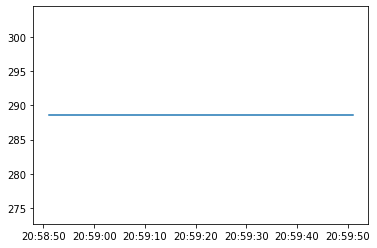

In [441]:
plt.plot(gpred2.mean['h.1'])

In [ ]:
'''GARCH Model Forecasting'''
# for d in range(foreLength):
    
#     # create a rolling window by selecting 
#     # values between d+1 and d+T of S&P500 returns
    
#     TS = lrets[(1+d):(windowLength+d)] 
    
#     # Find the best ARIMA fit 
#     # set d = 0 since we've already taken log return of the series
#     res_tup = _get_best_model(TS)
#     order = res_tup[1]
#     model = res_tup[2]
    
#     #now that we have our ARIMA fit, we feed this to GARCH model
#     p_ = order[0]
#     o_ = order[1]
#     q_ = order[2]
    
#     am = arch_model(model.resid, p=p_, o=o_, q=q_, dist='StudentsT')
#     res = am.fit(update_freq=5, disp='off')
    
#     # Generate a forecast of next day return using our fitted model
#     out = res.forecast(horizon=1, start=None, align='origin')
    
#     #Set trading signal equal to the sign of forecasted return
#     # Buy if we expect positive returns, sell if negative
      
#     signal.iloc[d] = np.sign(out.mean['h.1'].iloc[-1])

In [433]:
garch_prediction.

In [350]:
arima_22_forecast

,arima
TimeIndex,
2020-10-22 19:11:34,309.614204
2020-10-22 19:11:49,309.621134
2020-10-22 19:12:04,309.621134
2020-10-22 19:12:19,309.614204
2020-10-22 19:12:49,309.607274
...,...
2020-12-31 20:58:51,313.446476
2020-12-31 20:59:06,313.481126
2020-12-31 20:59:21,313.501916


In [354]:
df_bollinger = spy_and_var_for_ma.join(garch_prediction.variance).join(arima_22_forecast)

In [355]:
df_bollinger.r

,SPY_Last,VAR_1,h.1,arima
TimeIndex,,,,
2020-10-22 19:05:34,344.220,NaN,2479.449004,NaN
2020-10-22 19:05:49,344.275,NaN,2479.084660,NaN
2020-10-22 19:06:04,344.160,NaN,2476.421209,NaN
2020-10-22 19:06:19,343.970,NaN,2470.425587,NaN
2020-10-22 19:06:34,344.030,NaN,2466.988864,NaN
...,...,...,...,...
2020-12-31 20:58:51,374.260,374.207812,6102.434207,313.446476
2020-12-31 20:59:06,374.430,374.256287,6109.190332,313.481126
2020-12-31 20:59:21,374.320,374.529991,6110.854105,313.501916


In [357]:
df_bollinger.tail(100)

,SPY_Last,VAR_1,h.1,arima,20 Day MA,Upper Band,Lower Band
TimeIndex,,,,,,,
2020-12-31 20:34:21,373.4900,373.485203,5980.986677,313.508846,373.345195,528.018873,218.671517
2020-12-31 20:34:36,373.5000,373.517449,5984.234087,313.494986,373.352945,528.068608,218.637282
2020-12-31 20:34:51,373.4411,373.523845,5984.857730,313.494986,373.359250,528.082974,218.635526
2020-12-31 20:35:06,373.4700,373.413547,5986.279503,313.481126,373.365500,528.107602,218.623398
2020-12-31 20:35:21,373.4750,373.458487,5987.549549,313.481126,373.372250,528.130766,218.613734
...,...,...,...,...,...,...,...
2020-12-31 20:58:51,374.2600,374.207812,6102.434207,313.446476,374.153250,530.389407,217.917093
2020-12-31 20:59:06,374.4300,374.256287,6109.190332,313.481126,374.167750,530.490369,217.845131
2020-12-31 20:59:21,374.3200,374.529991,6110.854105,313.501916,374.177000,530.520904,217.833096


In [446]:
df_bollinger['20 Day MA'] = df_bollinger['SPY_Last'].rolling(20).mean()
df_bollinger['Upper Band'] = df_bollinger['20 Day MA'] + 2*np.sqrt(df_bollinger['h.1']/len(df_bollinger))
df_bollinger['Lower Band'] = df_bollinger['20 Day MA'] - 2*np.sqrt(df_bollinger['h.1']/len(df_bollinger))
# df_bollinger['Lower Band'] = df_bollinger['20 Day MA'] - 2*np.sqrt(df_bollinger['h.1'])

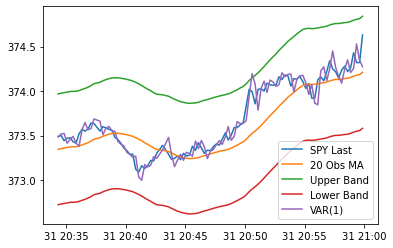

In [447]:
plt.plot(df_bollinger['SPY_Last'].iloc[-100:], label='SPY Last')
plt.plot(df_bollinger['20 Day MA'].iloc[-100:], label='20 Obs MA')
plt.plot(df_bollinger['Upper Band'].iloc[-100:], label='Upper Band')
plt.plot(df_bollinger['Lower Band'].iloc[-100:], label='Lower Band')
plt.plot(df_bollinger['VAR_1'].iloc[-100:], label='VAR(1)')
# plt.plot(predict_arima_test_sd, label='Forecast(1) SD of SPY Last - Test')
# plt.plot(df_delta_1, label='Delta')
plt.legend()

In [410]:
df_bollinger['5 Minute (20 obs) MA'] = df_bollinger['SPY_Last'].rolling(20).mean()
df_bollinger['Upper Band'] = df_bollinger['5 Minute (20 obs) MA'] + np.sqrt(df_bollinger['h.1']/len(df_bollinger))
df_bollinger['Lower Band'] = df_bollinger['5 Minute (20 obs) MA'] - np.sqrt(df_bollinger['h.1']/len(df_bollinger))
# df_bollinger['Lower Band'] = df_bollinger['20 Day MA'] - 2*np.sqrt(df_bollinger['h.1'])

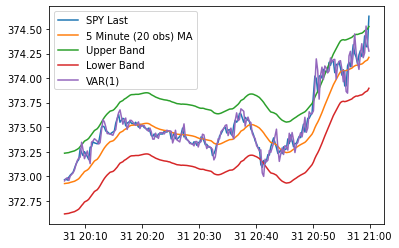

In [411]:
plt.plot(df_bollinger['SPY_Last'].iloc[-200:], label='SPY Last')
plt.plot(df_bollinger['5 Minute (20 obs) MA'].iloc[-200:], label='5 Minute (20 obs) MA')
plt.plot(df_bollinger['Upper Band'].iloc[-200:], label='Upper Band')
plt.plot(df_bollinger['Lower Band'].iloc[-200:], label='Lower Band')
plt.plot(df_bollinger['VAR_1'].iloc[-200:], label='VAR(1)')
# plt.plot(predict_arima_test_sd, label='Forecast(1) SD of SPY Last - Test')
# plt.plot(df_delta_1, label='Delta')
plt.legend()

In [376]:
df_bollinger['20 Day MA'] = df_bollinger['SPY_Last'].rolling(20).mean()
df_bollinger['Upper Band'] = df_bollinger['20 Day MA'] + 2*df_bollinger['SPY_Last'].rolling(20).std()
df_bollinger['Lower Band'] = df_bollinger['20 Day MA'] - 2*df_bollinger['SPY_Last'].rolling(20).std()
# df_bollinger['Lower Band'] = df_bollinger['20 Day MA'] - 2*np.sqrt(df_bollinger['h.1'])

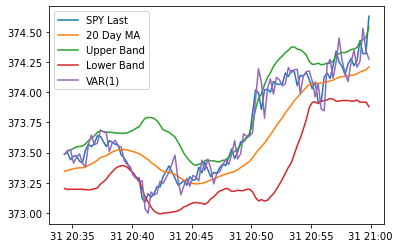

In [377]:
plt.plot(df_bollinger['SPY_Last'].iloc[-100:], label='SPY Last')
plt.plot(df_bollinger['20 Day MA'].iloc[-100:], label='20 Day MA')
plt.plot(df_bollinger['Upper Band'].iloc[-100:], label='Upper Band')
plt.plot(df_bollinger['Lower Band'].iloc[-100:], label='Lower Band')
plt.plot(df_bollinger['VAR_1'].iloc[-100:], label='VAR(1)')
# plt.plot(predict_arima_test_sd, label='Forecast(1) SD of SPY Last - Test')
# plt.plot(df_delta_1, label='Delta')
plt.legend()

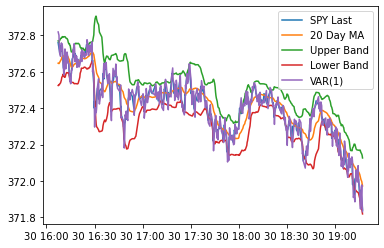

In [378]:
plt.plot(df_bollinger['SPY_Last'].iloc[-2000:-1500], label='SPY Last')
plt.plot(df_bollinger['20 Day MA'].iloc[-2000:-1500], label='20 Day MA')
plt.plot(df_bollinger['Upper Band'].iloc[-2000:-1500], label='Upper Band')
plt.plot(df_bollinger['Lower Band'].iloc[-2000:-1500], label='Lower Band')
plt.plot(df_bollinger['VAR_1'].iloc[-2000:-1500], label='VAR(1)')
# plt.plot(predict_arima_test_sd, label='Forecast(1) SD of SPY Last - Test')
# plt.plot(df_delta_1, label='Delta')
plt.legend()

In [404]:
# from statsmodels.tsa.statespace import varmax

In [407]:
# varmax_model = varmax.VARMAX(df_train_sd)
# varmax_1_fitted = varmax_model.fit(1, trend='nc')# Fit the model
# var_2 = VAR(df_train_sd)
# var_2_fitted = var_2.fit(2, trend='nc')# Fit the model
# print(var_2_fitted.summary())

In [406]:
df_train_sd

,SPY_Last,VIX_Last
TimeIndex,,
2019-01-02 14:31:34,0.0120,0.00
2019-01-02 14:31:49,0.0471,-0.03
2019-01-02 14:32:04,-0.1902,-0.03
2019-01-02 14:32:19,-0.0089,0.06
2019-01-02 14:32:34,0.1600,0.01
...,...,...
2020-06-11 18:24:05,-0.1500,-0.01
2020-06-11 18:24:20,0.0800,0.00
2020-06-11 18:24:35,0.1200,-0.13


Strategies to consider:
    - Buy\Short and then Hold for at least t=n (moving average window)
    - Buy & Hold
    - Standard Bollinger Bands based on actuals (rolling mean, 2*rolling std)
    - VAR/ARIMA/GARCH Forecast (1) on top of standard Bollinger Bands based on actuals (rolling mean, 1/1.5/2
    *GARCH volatility)